<a href="https://colab.research.google.com/github/da5nsy/ReplicatingKay2008/blob/master/tryingToReconstructImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pre-flight

In [1]:
# @title Load libraries 

import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import time

# Progress bar
# Source code: https://stackoverflow.com/a/46939639/6464224
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [2]:
# @title Load data 

# Source code: https://github.com/NeuromatchAcademy/course-content/blob/9f1fd9aafb65feec583703973c9edf0535d8a62e/projects/load_kay_images.ipynb

fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

with np.load(fname) as dobj:
  dat = dict(**dobj)

### Generate gabors, and project images into gabor space

In [3]:
# @title Define gabor functions

def gabor_fn(theta,lmbda,psi,gamma,x0=0,y0=0):
# % produce a gabor wavelet for the given sf,angle,phase,posi
# gamma does not seem to be used - it is always 1

    sigma = lmbda / 2
    sigma_x = sigma
    sigma_y = sigma / gamma
    # % Bounding box

    # %[x,y] = meshgrid(xmin:xmax,ymin:ymax);
    ygrid = range(-63,65)
    xgrid = range(-63,65)
    x, y = np.meshgrid(xgrid,ygrid)             #-63:64,-63:64);
    # % Rotation
    theta = np.deg2rad(theta) 
    psi = np.deg2rad(psi)
    x = x - x0
    y = y - y0
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gaussian_mask = np.exp(-.5*(x_theta**2/sigma_x**2+y_theta**2/sigma_y**2))
    gaussian_mask[gaussian_mask < (np.max(gaussian_mask)*0.01)] = 0

    sinusoid = np.cos(2*np.pi/lmbda*x_theta+psi);

    gb = gaussian_mask * sinusoid;

    return gb

def gaborfit():
# % produce a set of gabor wavelet directly

    out = display(progress(0, 100), display_id=True) #generate waitbar

    ang_rang = [0, 22.5000, 45.0000, 67.5000, 90.0000, 112.5000, 135.0000, 157.5000]
    gab = np.zeros([128,128,5456])
    count = 0
    for i in range(1,6): #=1:5
        FOV = 2**(i-1) #convoluted way to get [1,2,4,8,16]
        '''
        Spatial frequency tuning - goes through 1-5, producing FOV = 1,2,4,8,16
        '''
        lmbda = 128 / FOV # [128,64,32,16,8]
        if FOV == 1:
            x0 = 0 
            y0 = 0 
        elif FOV == 2:
            x0 = -32
            y0 = -32
        elif FOV == 4:
            x0 = -48
            y0 = -48
        elif FOV == 8:
            x0 = -56 
            y0 = -56 
        elif FOV == 16:
            x0 = -60 
            y0 = -60 

        for angle in ang_rang: #range(0,7*22.5+1,22.5)
            for j in range(FOV): #=0:FOV-1:
                for k in range(FOV): #=0:FOV-1:
                    gab[:,:,count] = gabor_fn(angle, lmbda, 0, 1, x0+j*lmbda, y0+k*lmbda);
                    count += 1
                    gab[:,:,count] = gabor_fn(angle, lmbda, 180, 1, x0+j*lmbda, y0+k*lmbda);
                    count += 1
                    if count % 20 == 0: 
                      out.update(progress(count, 5456)) # update waitbar
    out.update(progress(count, 5456)) # update waitbar
    return gab

In [4]:
gabor_wavelet_pyramid = gaborfit()

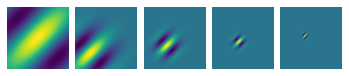

In [5]:
# @title Visaulize a sample of gabors (optional)
# Replicating sup figure 2


fig, axs = plt.subplots(1,5)
fig.subplots_adjust(wspace=.1)


idx = [4,34,156,648,2590] # only done by eye - might not be precisely correct values

for i in range(len(axs)):
  axs[i].imshow(gabor_wavelet_pyramid[:,:,idx[i]]);
  axs[i].axis('off')

In [7]:
### @title Project images into gabor space

proj = np.zeros((5,gabor_wavelet_pyramid.shape[2]//2))

out = display(progress(0, 100), display_id=True) #generate waitbar

for i in range(5): #training images 
  for j in range(0,gabor_wavelet_pyramid.shape[2],2):
    a = dat["stimuli"][i].reshape(-1)
    b = gabor_wavelet_pyramid[:,:,j].reshape(-1)
    c = gabor_wavelet_pyramid[:,:,j+1].reshape(-1)
    t1 = (a@b)/np.sqrt(b.T@b)
    t2 = (a@c)/np.sqrt(c.T@c)
    proj[i,(j+1)//2] = t1+t2

  out.update(progress(i, 5-1)) # update waitbar



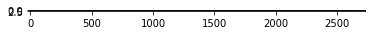

In [ ]:
plt.imshow(proj)

In [8]:
print(proj[:,64])

[ 0.00000000e+00  6.66133815e-16 -2.22044605e-16 -4.44089210e-16
 -2.08166817e-16]


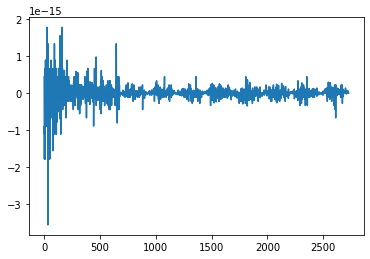

In [11]:
plt.plot(proj[0,:])

In [24]:
im0 = np.zeros_like(dat["stimuli"][0])

for i in range(proj.shape[1]):
  if proj[0,i] > 0:
    im0 = im0 + gabor_wavelet_pyramid[:,:,i*2]
  else:
    im0 = im0 + gabor_wavelet_pyramid[:,:,i*2+1]


  # for 0 I want 0 or 1
  # for 1 I want 2 or 3
  # for 2 I want 4 or 5

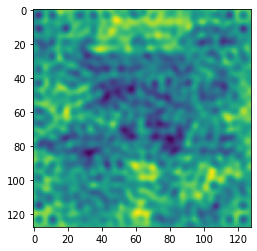

In [25]:
plt.imshow(im0)